# Digital signal processing: filtering

**Filtering** is a key DSP operation that modifies the frequency content of a signal. Filters can be used to remove unwanted components or enhance certain frequencies.

More on filters can be read from this [freebook][filter_book]. [LTI Digital filters chapter][filter_book_lti] is recommended.  

[filter_book]: https://www.dsprelated.com/freebooks/filters/
[filter_book_lti]: https://www.dsprelated.com/freebooks/filters/Linear_Time_Invariant_Digital_Filters.html


Filters can be categorized as `linear` filters and `nonlinear` filters. Furthermore, we will only cover the basics of `Linear Time-Invariant (LTI)` filters, as only LTI filters are subjected to frequency-domain analysis and they are the only filters that preserve signal frequencies. On the other hand, nonlinear filters generally create new sinusoidal components at all sums and differences of the frequencies present in the input signal. This includes both **harmonic distortion** (when the input signal is periodic) and **intermodulation distortion** (when at least two inharmonically related tones are present). A truly linear filter does not cause harmonic or intermodulation distortion. ([Source][filter_book_lti])

## Linear Time Invariant (LTI) Filters

A **Linear Time-Invariant (LTI)** filter is a system that satisfies the properties of linearity and time invariance. These filters are essential in digital signal processing, where they modify or extract specific information from a signal without changing its fundamental structure. 

The generic form of an LTI filter can be expressed using the **difference equation**:

$$
y[n] = ∑_{k=0}^{N} b_k * x[n-k] - ∑_{m=1}^{M} a_m * y[n-m]
$$

where `x[n]` is the input signal, `y[n]` is the output signal, `b_k` are the
filter coefficients for the current and previous input samples, `a_m` are the
filter coefficients for the previous output samples, `N` is the filter order for
the input (FIR part),  `M` is the filter order for the output (IIR part).

Types of LTI filters by application:

- **Low-pass filter**: Allows frequencies below a cutoff to pass, blocking higher frequencies.
- **High-pass filter**: Allows frequencies above a cutoff to pass, blocking lower frequencies.
- **Band-pass filter**: Allows frequencies within a specific range to pass.

Types of LTI filters by definition:

- **FIR (Finite Impulse Response)** 
- **IIR (Infinite Impulse Response)**

We will analyze different types of filters (low-pass, high-pass etc) using different LTI filters (FIR and IIR). 

### Data

For this example, we will use a generated signal with different frequencies and modify the frequency components of the signal using LTI filters

In [21]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, firwin, lfilter, butter, group_delay
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Function to plot magnitude and phase response of signals
def plot_signal_response(signal, fs, title):
    # Compute FFT
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft_signal), 1/fs)

    # Keep only positive frequencies
    idx = np.where(freqs >= 0)
    fft_signal = fft_signal[idx]
    freqs = freqs[idx]

    # Magnitude and phase response
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 6))

    # Time domain signal
    ax0.plot(t, signal, 'b')
    ax0.set_title(f'{title} - Time Domain Signal')
    ax0.set_xlabel('Time [s]')
    ax0.set_ylabel('Amplitude')
    ax0.grid()

    # Magnitude response
    ax1.plot(freqs, np.abs(fft_signal), 'b')
    ax1.set_title(f'{title} - Magnitude Response')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Magnitude')
    ax1.grid()

    # Phase response
    ax2.plot(freqs, np.unwrap(np.angle(fft_signal)), 'r')
    ax2.set_title(f'{title} - Phase Response')
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Phase [radians]')
    ax2.grid()

    plt.tight_layout()
    plt.show()

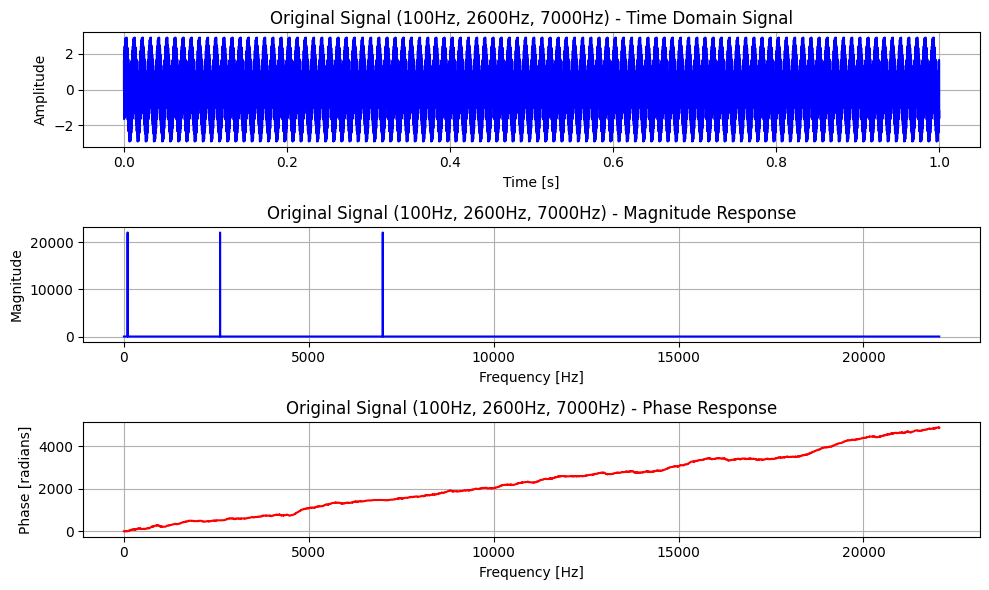

In [23]:
# Sampling parameters
fs = 44100  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time array, 1 second

# Create a signal with low, mid, and high frequencies
low_freq = 100
mid_freq = 2600
high_freq = 7000

signal = (np.sin(2 * np.pi * low_freq * t) +
          np.sin(2 * np.pi * mid_freq * t) +
          np.sin(2 * np.pi * high_freq * t))

# Plot responses for input and filtered signals
plot_signal_response(signal, fs, f"Original Signal ({low_freq}Hz, {mid_freq}Hz, {high_freq}Hz)")

# Play the original signal
Audio(signal, rate=fs)

### **FIR Filters (Finite Impulse Response)**

For **FIR** filters, the output depends only on the current and past input values and does not depend on past outputs. The difference equation simplifies to:

$$
y[n] = ∑_{k=0}^{N} b_k * x[n-k]
$$

- FIR filters are inherently stable because they do not have feedback (no `a_m` terms).
- They often have a **linear phase response**, meaning all frequency components are delayed equally.

In [24]:
# Function to plot magnitude and phase response
def plot_freq_response(b, fs, a = 1, cutoffs = None, title= 'Filter'):
    if not cutoffs:
        cutoffs = []
    w, h = freqz(b, a, worN=8000)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

    # Magnitude response
    ax1.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
    for cutoff in cutoffs:
        ax1.axvline(cutoff, color='k', linestyle='--')
    ax1.set_title(f'{title} - Magnitude Response')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Magnitude')
    ax1.grid()

    # Phase response
    ax2.plot(0.5 * fs * w / np.pi, np.unwrap(np.angle(h)), 'r')
    for cutoff in cutoffs:
        ax2.axvline(cutoff, color='k', linestyle='--')
    ax2.set_title(f'{title} - Phase Response')
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Phase [radians]')
    ax2.grid()

    plt.tight_layout()
    plt.show()



In [25]:
# FIR filter design parameters
numtaps = 101  # Number of filter coefficients (taps)

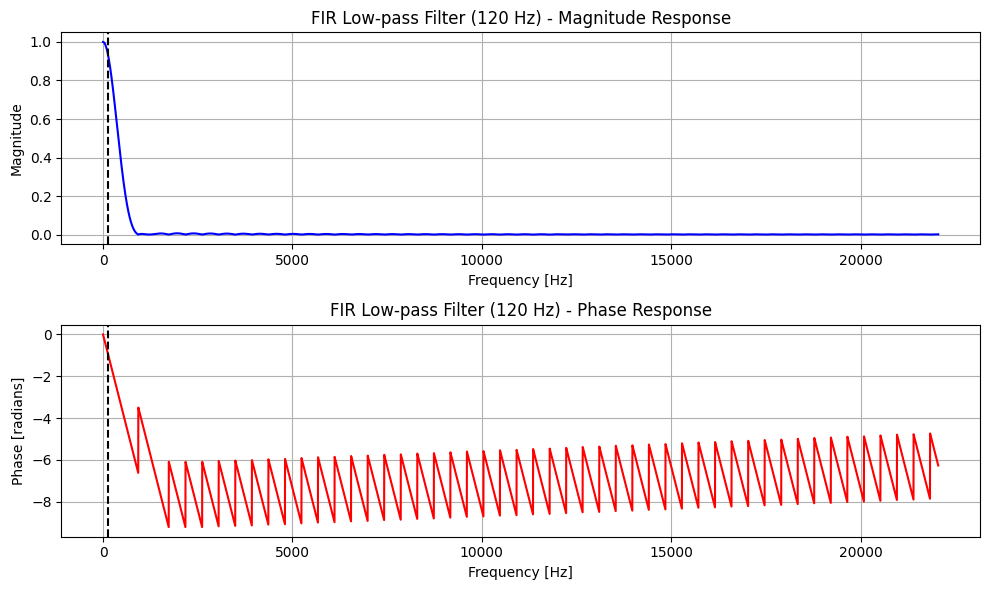

In [26]:
# Low-pass filter design
low_cutoff = low_freq * 1.2
low_pass_fir = firwin(numtaps, low_cutoff, fs=fs ,pass_zero='lowpass')
# Plot FIR filter responses
plot_freq_response(
    b=low_pass_fir,
    fs=fs,
    a=1,
    cutoffs=[low_cutoff],
    title=f"FIR Low-pass Filter ({low_cutoff:.0f} Hz)"
)

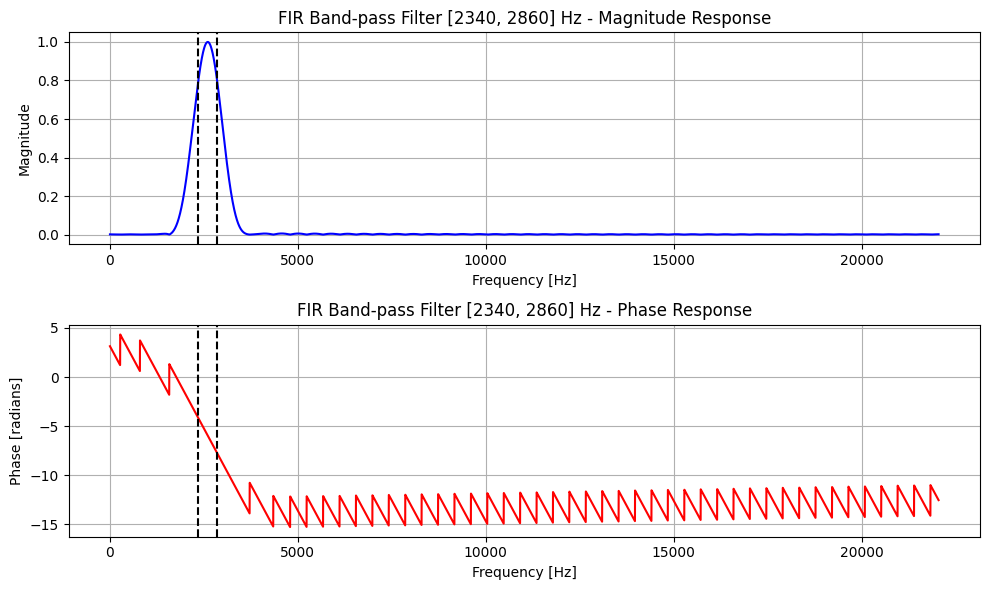

In [27]:
# Band-pass filter design
band_cutoff = [mid_freq * 0.9, mid_freq * 1.1]
band_pass_fir = firwin(numtaps, band_cutoff, fs=fs, pass_zero='bandpass')

plot_freq_response(
    b=band_pass_fir,
    fs=fs,
    a=1,
    cutoffs=band_cutoff,
    title=f"FIR Band-pass Filter [{band_cutoff[0]:.0f}, {band_cutoff[1]:.0f}] Hz"
)

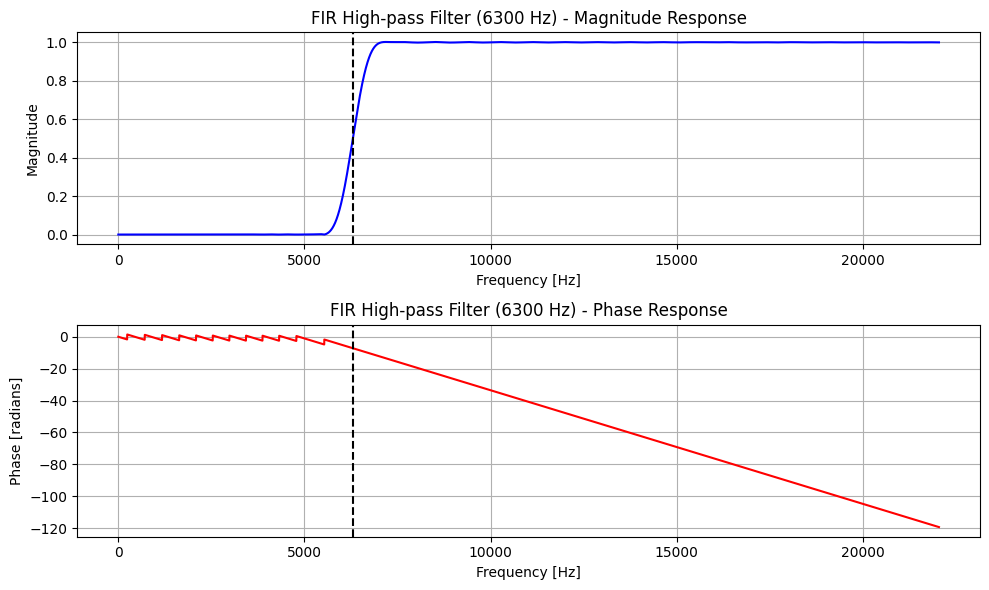

In [28]:
# High-pass filter design
high_cutoff = high_freq * 0.9
high_pass_fir = firwin(numtaps, high_cutoff, fs=fs, pass_zero='highpass')
plot_freq_response(
    b=high_pass_fir,
    fs=fs,
    a=1,
    cutoffs=[high_cutoff],
    title=f"FIR High-pass Filter ({high_cutoff:.0f} Hz)"
)

Let's also plot the group delays to show that linear phase filters won't cause phase distortion

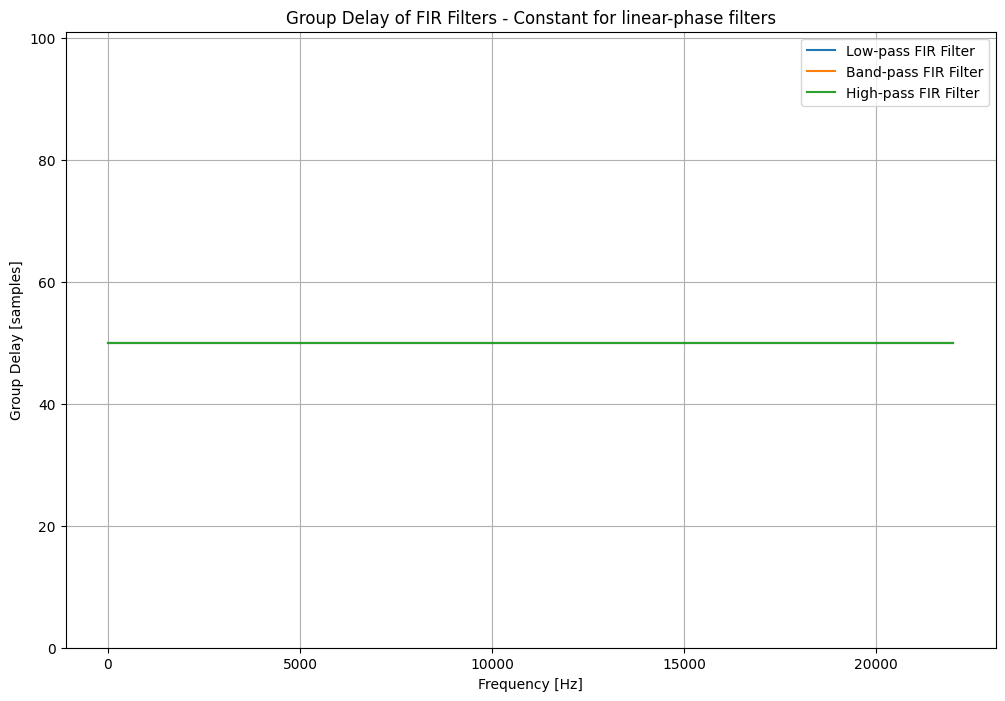

In [29]:
# Compute group delay for low-pass filter
frequencies_lp, gd_lp = group_delay((low_pass_fir, 1), fs=fs)

# Compute group delay for band-pass filter
frequencies_bp, gd_bp = group_delay((band_pass_fir, 1), fs=fs)

# Compute group delay for high-pass filter
frequencies_hp, gd_hp = group_delay((high_pass_fir, 1), fs=fs)

# Plot group delay
plt.figure(figsize=(12, 8))

plt.plot(frequencies_lp, gd_lp, label='Low-pass FIR Filter')
plt.plot(frequencies_bp, gd_bp, label='Band-pass FIR Filter')
plt.plot(frequencies_hp, gd_hp, label='High-pass FIR Filter')

plt.title('Group Delay of FIR Filters - Constant for linear-phase filters')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group Delay [samples]')
plt.ylim(0, numtaps)
plt.legend()
plt.grid()
plt.show()

Now that we created the FIR filters, we will apply the filters to the original signal and see how the frequency content changes with each filter.

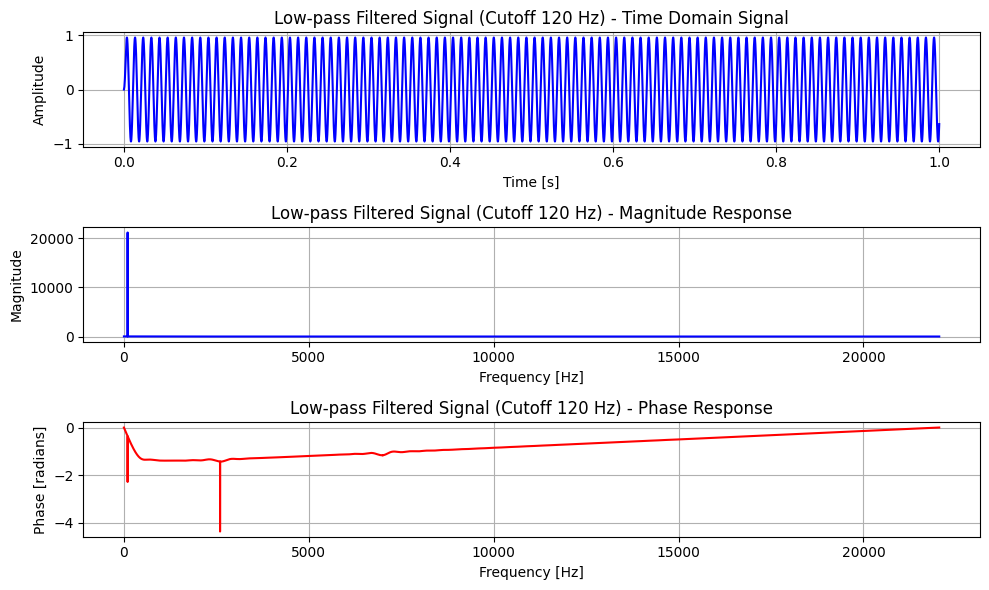

Low-pass Filtered Signal


In [30]:
# Apply low-pass filter
low_pass_signal = lfilter(low_pass_fir, 1.0, signal)
plot_signal_response(low_pass_signal, fs, f"Low-pass Filtered Signal (Cutoff {low_cutoff:.0f} Hz)")
# Play the filtered signals
print("Low-pass Filtered Signal")
Audio(low_pass_signal, rate=fs)

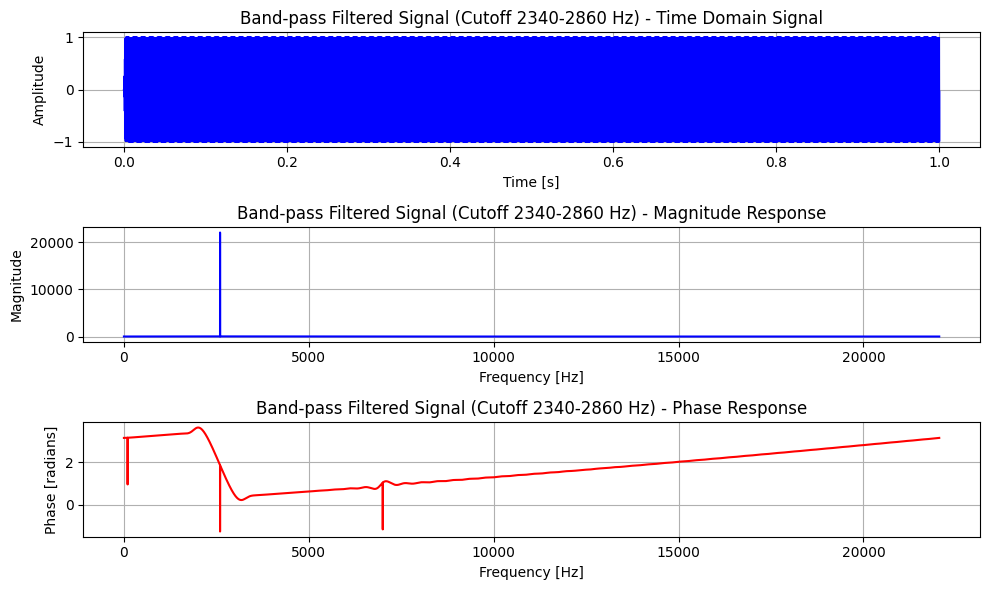

Band-pass Filtered Signal


In [31]:
# Apply band-pass filter
band_pass_signal = lfilter(band_pass_fir, 1.0, signal)
plot_signal_response(band_pass_signal, fs, f"Band-pass Filtered Signal (Cutoff {band_cutoff[0]:.0f}-{band_cutoff[1]:.0f} Hz)")
# Play the filtered signals
print("Band-pass Filtered Signal")
Audio(band_pass_signal, rate=fs)

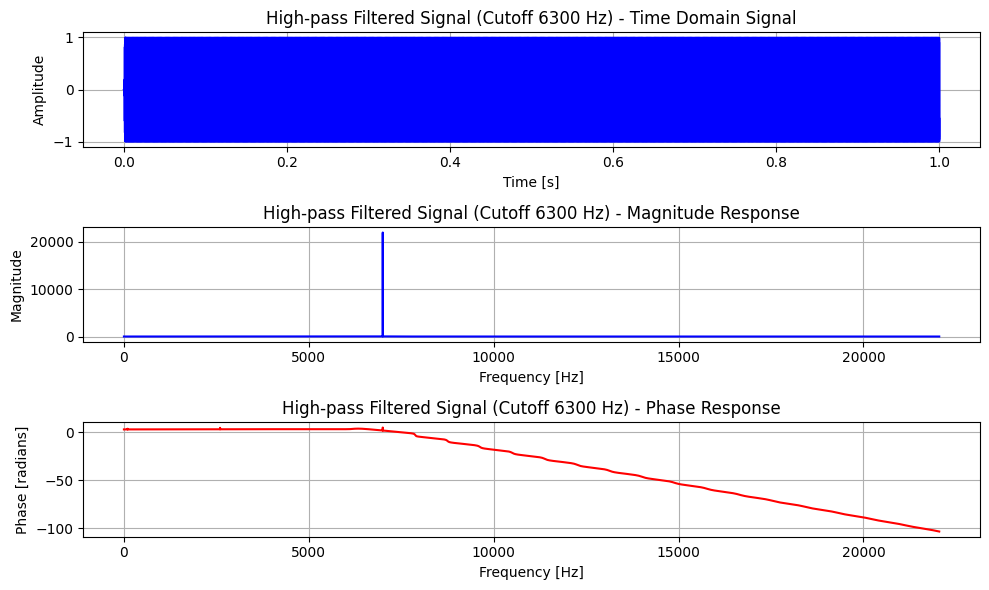

High-pass Filtered Signal


In [32]:
# Apply high-pass filter
high_pass_signal = lfilter(high_pass_fir, 1.0, signal)
plot_signal_response(high_pass_signal, fs, f"High-pass Filtered Signal (Cutoff {high_cutoff:.0f} Hz)")
# Play the filtered signals
print("High-pass Filtered Signal")
Audio(high_pass_signal, rate=fs)

Note that the phase response is still linear, as all the FIR filters so were linear-phase filters, not causing any phase distortion.

### **IIR Filters (Infinite Impulse Response)**


In **IIR** filters, the output depends not only on the current and past input values but also on the past output values. This introduces feedback, and the difference equation becomes:

$$
y[n] = ∑_{k=0}^{N} b_k * x[n-k] - ∑_{m=1}^{M} a_m * y[n-m]
$$


- IIR filters are computationally efficient because they can achieve sharp frequency responses with fewer coefficients.
- They may exhibit **non-linear phase** characteristics due to the feedback (recursive nature), leading to **phase distortion** in some cases. 

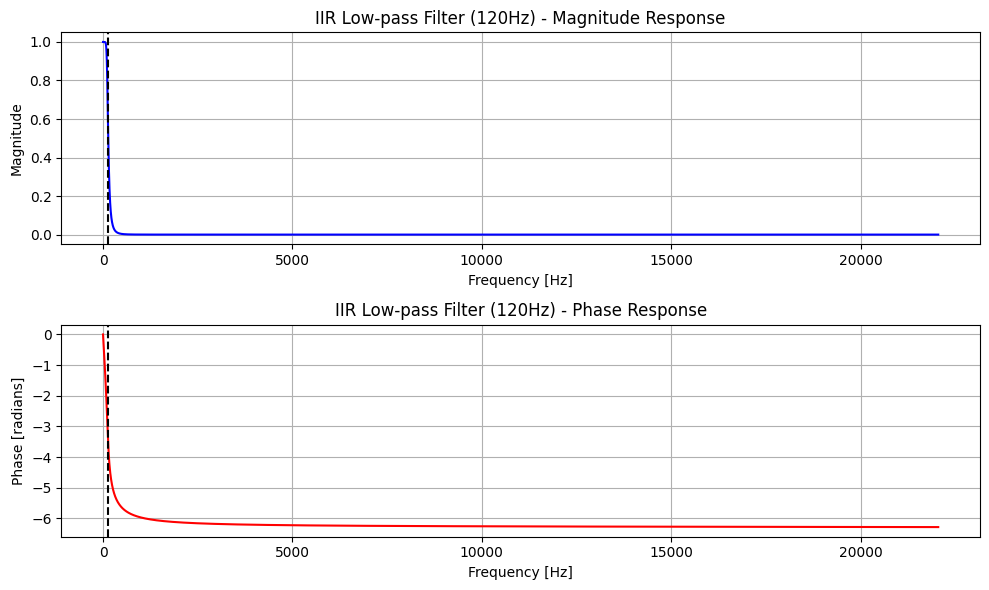

In [33]:
# IIR Low-pass filter design
low_pass_iir_b, low_pass_iir_a = butter(4, low_cutoff, btype='low', fs=fs)

# Plot IIR filter responses
plot_freq_response(
    b=low_pass_iir_b,
    fs=fs,
    a=low_pass_iir_a,
    cutoffs=[low_cutoff],
    title=f"IIR Low-pass Filter ({low_cutoff:.0f}Hz)"
)

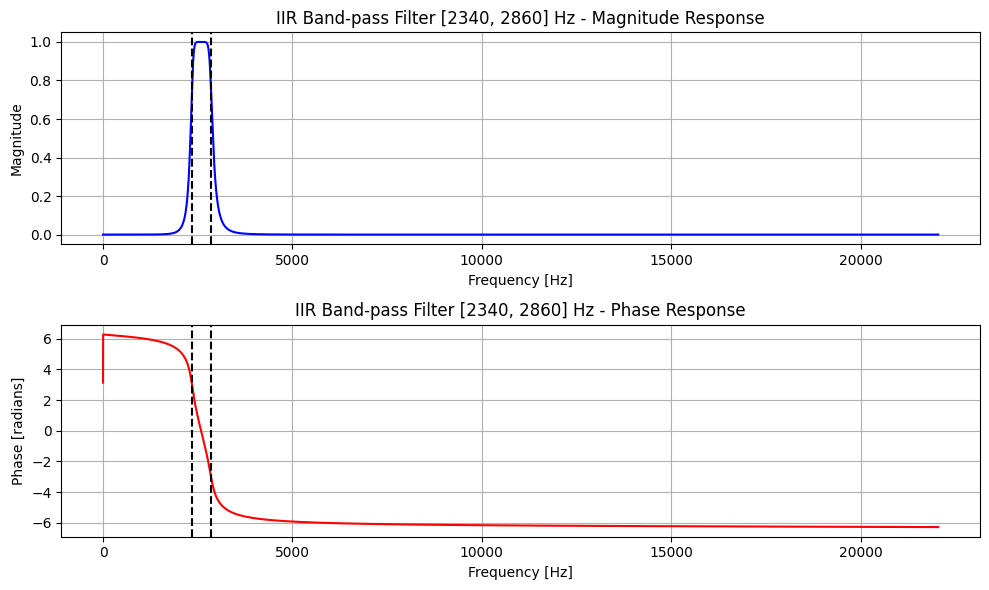

In [34]:
# IIR Band-pass filter design
band_pass_iir_b, band_pass_iir_a = butter(4, band_cutoff, btype='band', fs=fs)

# Plot IIR filter responses
plot_freq_response(
    b=band_pass_iir_b,
    fs=fs,
    a=band_pass_iir_a,
    cutoffs=band_cutoff,
    title=f"IIR Band-pass Filter [{band_cutoff[0]:.0f}, {band_cutoff[1]:.0f}] Hz"
)

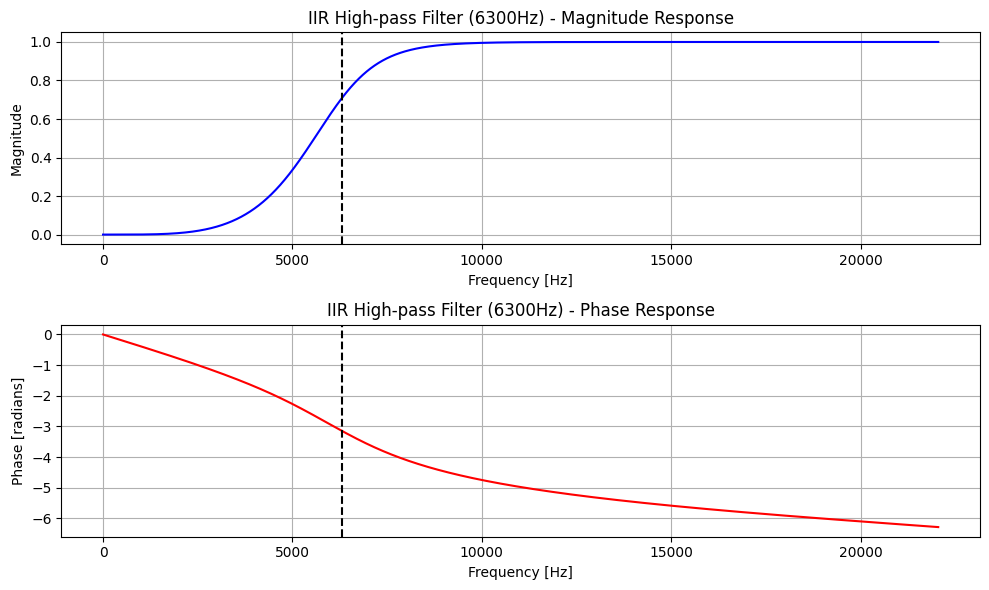

In [35]:
# High-pass filter design
high_pass_iir_b, high_pass_iir_a = butter(4, high_cutoff, btype='high', fs=fs)
# Plot IIR filter responses
plot_freq_response(
    b=high_pass_iir_b,
    fs=fs,
    a=high_pass_iir_a,
    cutoffs=[high_cutoff],
    title=f"IIR High-pass Filter ({high_cutoff:.0f}Hz)"
)

Similarly for IIR filters, let's also plot the group delays (the delay introduced by the filter for each frequency component)

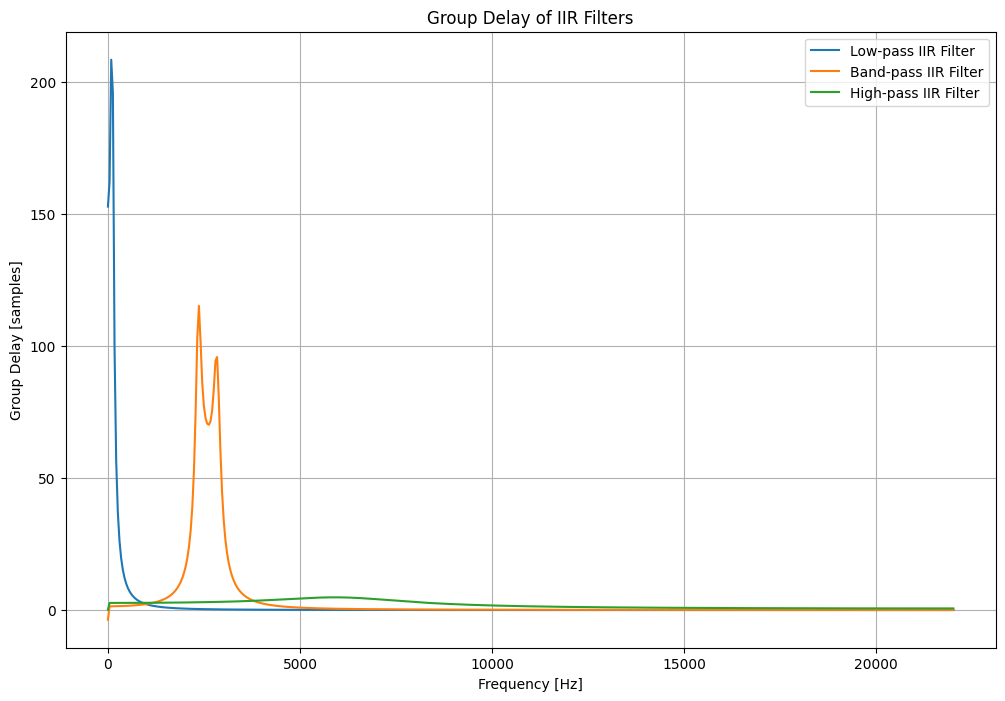

In [36]:
# Compute group delay for low-pass IIR filter
frequencies_lp_iir, gd_lp_iir = group_delay((low_pass_iir_b, low_pass_iir_a), fs=fs)

# Compute group delay for band-pass IIR filter
frequencies_bp_iir, gd_bp_iir = group_delay((band_pass_iir_b, band_pass_iir_a), fs=fs)

# Compute group delay for high-pass IIR filter
frequencies_hp_iir, gd_hp_iir = group_delay((high_pass_iir_b, high_pass_iir_a), fs=fs)

# Plot group delay
plt.figure(figsize=(12, 8))

plt.plot(frequencies_lp_iir, gd_lp_iir, label='Low-pass IIR Filter')
plt.plot(frequencies_bp_iir, gd_bp_iir, label='Band-pass IIR Filter')
plt.plot(frequencies_hp_iir, gd_hp_iir, label='High-pass IIR Filter')

plt.title('Group Delay of IIR Filters')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Group Delay [samples]')
plt.legend()
plt.grid()
plt.show()

Now that we created the IIR filters, we will apply the filters to the original signal and see how the frequency content changes with each filter.

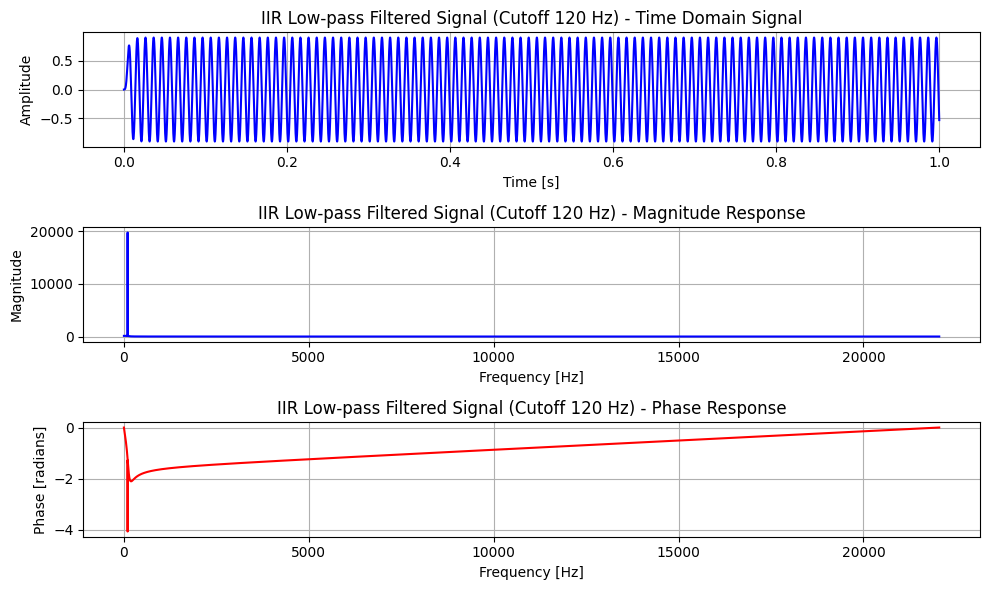

IIR Low-pass Filtered Signal


In [37]:
# IIR filter low-pass filter
low_pass_signal_iir = lfilter(low_pass_iir_b, low_pass_iir_a, signal)

plot_signal_response(low_pass_signal_iir, fs, f"IIR Low-pass Filtered Signal (Cutoff {low_cutoff:.0f} Hz)")

# Play the filtered signals
print("IIR Low-pass Filtered Signal")
Audio(low_pass_signal_iir, rate=fs)

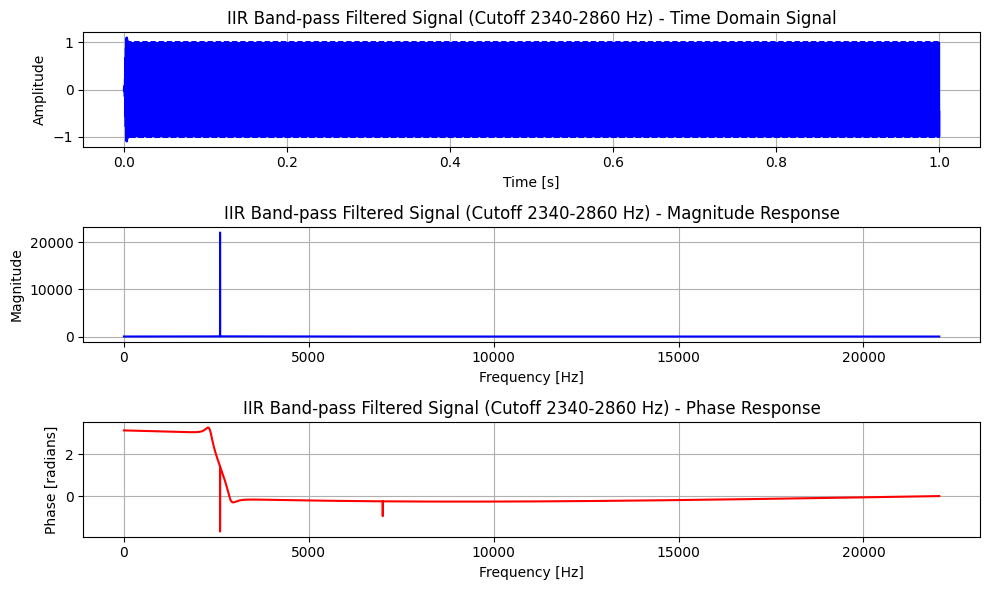

IIR Band-pass Filtered Signal


In [38]:
band_pass_signal_iir = lfilter(band_pass_iir_b, band_pass_iir_a, signal)
plot_signal_response(band_pass_signal_iir, fs, f"IIR Band-pass Filtered Signal (Cutoff {band_cutoff[0]:.0f}-{band_cutoff[1]:.0f} Hz)")
# Play the filtered signals
print("IIR Band-pass Filtered Signal")
Audio(band_pass_signal_iir, rate=fs)

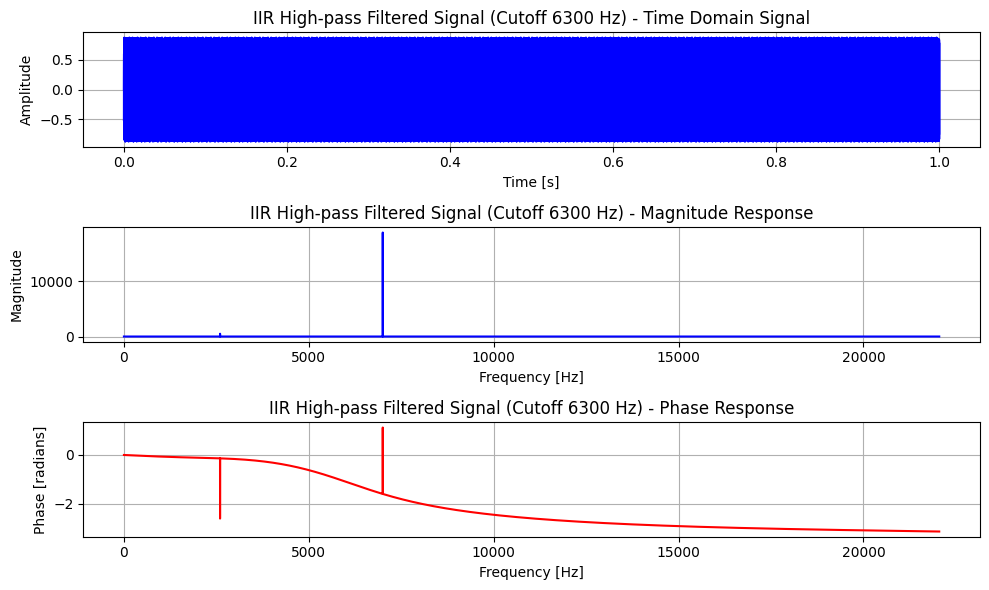

IIR High-pass Filtered Signal


In [39]:
high_pass_signal_iir = lfilter(high_pass_iir_b, high_pass_iir_a, signal)
plot_signal_response(high_pass_signal_iir, fs, f"IIR High-pass Filtered Signal (Cutoff {high_cutoff:.0f} Hz)")
# Play the filtered signals
print("IIR High-pass Filtered Signal")
Audio(high_pass_signal_iir, rate=fs)

Note that the phase response is **distorted**, as the IIR filter is not linear-phase, causing phase distortion.

## Conclusion

In summary, both FIR and IIR filters are LTI filters, but they differ in structure, stability, and phase response. 

- FIR filters are simpler and stable but computationally expensive for high-order designs,
- IIR filters are more efficient (required filter order is smaller for the same requirements), but can introduce stability and phase issues.